<a href="https://colab.research.google.com/github/andyrids/hybrid-association/blob/main/Hybrid_Spatio_temporal_Association_Within_Standardised_%26_Non_standardised_Space.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.ticker import FixedLocator, AutoLocator, AutoMinorLocator
from mpl_toolkits.mplot3d import Axes3D

## Confidence Calculations

The confidence metrics in this spatio-temporal clustering approach are designed to quantify the certainty that an event and track are meaningfully associated.

### Spatial Confidence

This confidence value is calculated using the following formula:

$spatial\_confidence = 1.0 - \left(\frac{min\_distance}{threshold}\right)$

This represents a linear normalization of Euclidean distance in ECEF coordinates.

*   $min\_distance$: Minimum distance (meters) between an event and track coordinates.
*   $threshold$: Maximum allowable distance (meters) for association
*   $ratio$: $\frac{min\_distance}{threshold}\in[0,1]$
*   $confidence\_inversion$: 1.0 - $ratio$

This creates a **linear decay function**, which is a type of function that decreases at a constant rate over time or distance. This function is represented by a straight line with a negative slope when graphed. As $min\_distance$ increases, $spatial\_confidence$ decreases at a constant rate.

If $distance\_threshold = 1000$:

*   Perfect spatial overlap (0m) → 1.0 confidence
*   Maximum distance (1000m) → 0.0 confidence
*   Half threshold distance (500m) → 0.5 confidence

This linear relationship suggests that halving the distance doubles the confidence and there are no confidence discontinuities.

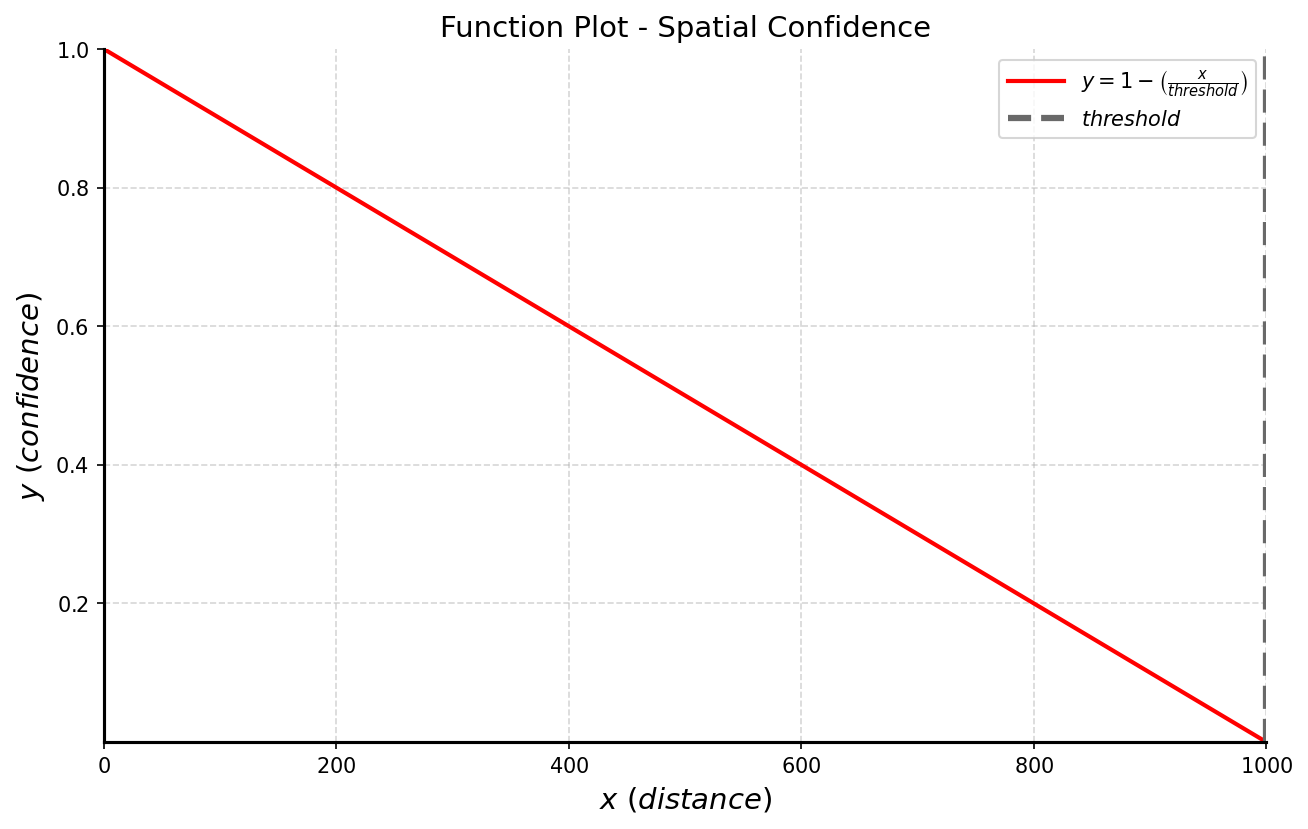

In [76]:
# f(x) = 1.0 - (x / THRESHOLD)

THRESHOLD = 1000
x = np.linspace(0, THRESHOLD, 100)
y = 1.0 - (x / THRESHOLD)

fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
ax.plot(x, y, color="r", label=r'$y = 1 - \left(\frac{x}{threshold}\right)$', linewidth=2)

ax.axvline(THRESHOLD, ls='--', color='dimgrey', linewidth=3, label=r'$threshold$')

ax.set_title("Function Plot - Spatial Confidence", fontsize=14)

ax.set(
    xlim=(-0, 1000),
    ylim=(-0, 1),
    yticks=list(filter(bool, np.linspace(0, 1, 6)))
)

ax.xaxis.set_major_locator(AutoLocator())

ax.ticklabel_format(useMathText=True)
ax.grid(alpha=.5, linestyle="--")

ax.set_xlabel(r'$x \ (distance)$', fontsize=14, position="right")
ax.set_ylabel(r'$y \ (confidence)$', fontsize=14, position="top")

ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")

ax.spines[["top", "right"]].set_visible(False)
ax.spines[["bottom", "left"]].set_position("zero")
ax.spines["bottom"].set(linewidth=1.5)
ax.spines["left"].set(linewidth=1.5)

xgrid_lines = ax.get_xgridlines()
ygrid_lines = ax.get_ygridlines()
xgrid_lines[0].set_visible(False)
ygrid_lines[-1].set_visible(False)

ax.legend(handlelength=2.7, fontsize='medium', fancybox=True)
plt.show()

In [ ]:
plt.close("all")

### Temporal Confidence

The temporal confidence is calculated using the following formula:

$temporal\_confidence = \left. 1.0 \middle/ \left(1.0 + \frac{seconds}{3600}\right)\right.$

This is based on a rational function with asymptotic behavior:

*   $seconds$: Absolute time difference (seconds)
*   $factor$: 3600 (converts seconds to hours)
*   Function: $f(t)=1/\left(1+t\right)$ ($t$ is time in hours)

This gives a hyperbolic decay where the output decreases rapidly at first and then slows down, approaching but never quite reaching zero. It's characterized by a hyperbolic curve when plotted on a graph. This function choice was based on the assumption that small time differences are much more significant than large ones. There is a long tail as even with substantial time differences, some minimal association remains possible. The confidence score always ranges  $\in[0,1]$

*   Temporal overlap (0s): 1.0 confidence
*   1 hour difference: 0.5 confidence
*   3 hour difference: 0.25 confidence
*   11 hour difference: 0.083 confidence

Temporal proximity has diminishing returns beyond certain thresholds.

In [64]:
seconds = 15 * 60

In [65]:
1 / (1 + (seconds / 3600)), seconds / 3600

(0.8, 0.25)

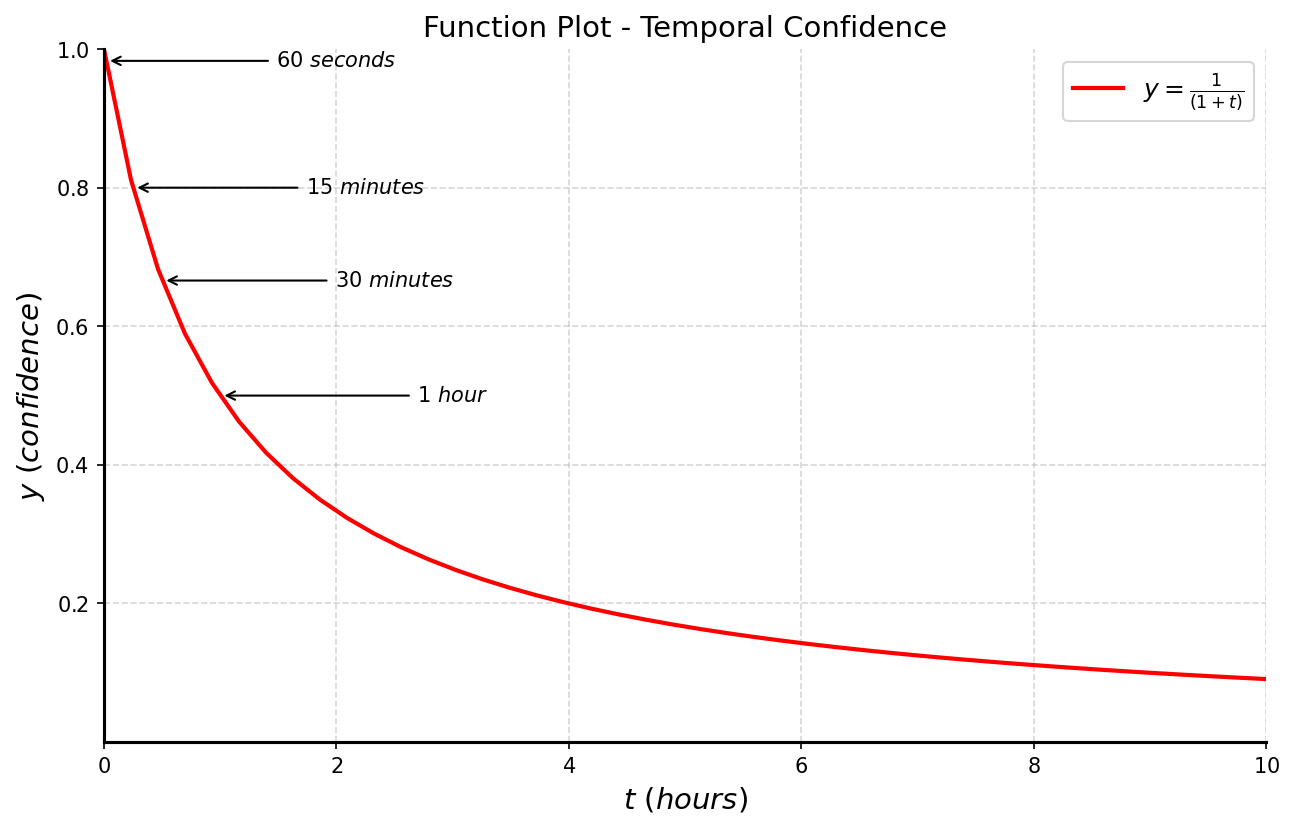

In [77]:
# $f(t)=1/\left(1+t\right)$ ($t$ is time in hours)
# f(t)=1/(1+t)

x = np.linspace(0, 10, 44)
y = 1.0 / (1 + x)

fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
ax.plot(x, y, color="r", label=r'$y = \frac{1}{\left(1+t\right)}$', linewidth=2)

ax.annotate(
    r'$60 \ seconds$',
    xy=(0.0166, 0.983),
    xycoords="data",
    xytext=(2, 0.983),
    arrowprops=dict(arrowstyle="->", facecolor='black'),
    ha="center",
    va="center"
)

ax.annotate(
    r'$15 \ minutes$',
    xy=(0.25, 0.8),
    xycoords="data",
    xytext=(2.25, 0.8),
    arrowprops=dict(arrowstyle="->", facecolor='black'),
    ha="center",
    va="center"
)

ax.annotate(
    r'$30 \ minutes$',
    xy=(0.5, 0.666),
    xycoords="data",
    xytext=(2.5, 0.666),
    arrowprops=dict(arrowstyle="->", facecolor='black'),
    ha="center",
    va="center"
)

ax.annotate(
    r'$1 \ hour$',
    xy=(1, 0.5),
    xycoords="data",
    xytext=(3, 0.5),
    arrowprops=dict(arrowstyle="->", facecolor='black'),
    ha="center",
    va="center"
)

ax.set_title("Function Plot - Temporal Confidence", fontsize=14)

ax.set(
    xlim=(0, 10),
    ylim=(0, 1),
    yticks=list(filter(bool, np.linspace(0, 1, 6)))
)

ax.xaxis.set_major_locator(AutoLocator())

ax.ticklabel_format(useMathText=True)
ax.grid(alpha=.5, linestyle="--")

ax.set_xlabel(r'$t \ (hours)$', fontsize=14, position="right")
ax.set_ylabel(r'$y \ (confidence)$', fontsize=14, position="top")

ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")

ax.spines[["top", "right"]].set_visible(False)
ax.spines[["bottom", "left"]].set_position("zero")
ax.spines["bottom"].set(linewidth=1.5)
ax.spines["left"].set(linewidth=1.5)

xgrid_lines = ax.get_xgridlines()
ygrid_lines = ax.get_ygridlines()
xgrid_lines[0].set_visible(False)
ygrid_lines[-1].set_visible(False)

ax.legend(handlelength=2, fontsize='large', fancybox=True)
plt.show()

In [78]:
plt.close("all")